# PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS
## NÚCLEO DE EDUCAÇÃO A DISTÂNCIA
## Pós-graduação Lato Sensu em Ciência de Dados e Big Data


## Cássio Luís José Barbosa


## AGRUPAMENTO DE MUNICÍPIOS PARA LEILÕES DE CONCESSÃO DE SERVIÇOS DE SANEAMENTO BÁSICO USANDO TÉCNICAS DE MACHINE LEARNING


## Campinas-SP
## 2020

## Versão do script: 1.21.1

## Bibliotecas importadas

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import re
import researchpy as rp
import seaborn as sns
import unidecode
import scipy.stats as stats

from IPython.core.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_text
from scipy import stats

C:\Users\cassio\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


## Configurações do ambiente

In [2]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [3]:
plt.style.use('fivethirtyeight')

In [4]:
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [5]:
pd.options.mode.chained_assignment = None

In [6]:
pd.options.display.float_format = '{:,.2f}'.format

## Constantes

In [7]:
REGIAO_ANALISADA = "Nordeste"

## Biblioteca de funções do script

In [8]:
#Função para efetuar uma descrição estatística personalizada
def describe_personalizado(df):
    desc = df.describe().copy()
    part_desc = desc.loc[desc.index.isin(['mean', 'std'])]
    std = part_desc.loc[part_desc.index.isin(['std'])].values.tolist()[0]
    mean = part_desc.loc[part_desc.index.isin(['mean'])].values.tolist()[0]
    std_pc = [(a / b)  for a, b in zip(std, mean)]
    part_desc.loc[len(part_desc)] = std_pc
    part_desc.rename(index={2:'std / mean'}, inplace=True)
    return part_desc

In [9]:
#Função para calcular porcentagem
def calc_percentual(x,tot):
    return (int(x)/int(tot))*100

In [10]:
#Função para calcular porcentagem com limite máximo de 100%
def calc_percentual_com_valor_maximo(x,tot):
    if (int(tot) == 0):
        return 0
    return min(  (int(x)/int(tot))*100, 100  )

In [11]:
#Calcula o volume de agua tratada disponível
def calc_VOL_AGUA_TRATADA_DISP(ag007, ag015, ag018, ag019):
    return int(ag007) + int(ag015) + int(ag018) - int(ag019)

In [12]:
#Calcula o volume de agua tratada disponível per capita
def calc_VOL_AGUA_TRATADA_DISP_PER_CAPITA(ag007, ag015, ag018, ag019, pop):
    return (int(ag007) + int(ag015) + int(ag018) - int(ag019))*1000 / int(pop)

In [13]:
#Calcula o volume de esgoto coletado per capita
def calc_VOL_ESGOTO_COLETADO_PER_CAPITA(es005, pop):
    return int(es005)*1000 / int(pop)

In [14]:
#Função para compor o código do município no padrão IBGE a partir de um código de UF e 
#código de município.
#O código de municípios do IBGE possui 7 caracteres, sendo que os dois primeiros representam 
#o estado da federação, os quatro seguintes o código do município dentro do estado e o 
#último é um dígito verificador.
def comp_cod_munic_ibge(co_uf, co_mu):
    co_uf = str(int(co_uf))
    co_mu = str(int(co_mu))
    return (co_uf.strip().zfill(2) + co_mu.strip().zfill(5))[0:6]

In [15]:
#Função para padronizar um código de município para 6 caracteres
def padroniza_cod_munic_ibge(co_mu):
    co_mu = str(int(co_mu))
    return co_mu.strip().zfill(6)[0:6]

## Importação dos dados

In [16]:
#Ministério do Desenvolvimento Regional, SNIS (Sistema Nacional de Informações sobre 
#Saneamento)
#Informações e indicadores municipais consolidados do ano de 2018
#URL da fonte: http://app4.mdr.gov.br/serieHistorica/#

dt_mdr_snis = pd.read_csv("../Dados/MDR - SNIS/Dataset/ConsolidadoMunicipio-20200704150919.csv", sep=";", decimal=",", thousands=".", encoding="utf8")

In [17]:
#IBGE - Produto Interno Bruto dos Municípios (dados de 2010-2017)
#URL da fonte: https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9088-produto-interno-bruto-dos-municipios.html?=&t=o-que-e

dt_ibge_pib = pd.read_csv("../Dados/IBGE- PIB dos Municípios/Dataset/PIB dos Municípios - base de dados 2010-2017.csv", sep=";", decimal=",", thousands=".", low_memory=False, encoding="utf8")

#Filtra apenas o anos mais recente de 2017
dt_ibge_pib = dt_ibge_pib[dt_ibge_pib['ANO'] == 2017]

### Verificando a quantidade de registros e colunas dos dataframes

In [125]:
dt_mdr_snis.shape

(5570, 24)

In [126]:
dt_ibge_pib.shape

(5570, 43)

### Verificando o tipo de dados atribuídos na importação

In [18]:
dt_mdr_snis.dtypes.to_frame()

,0
CODIGO_DO_MUNICIPIO,int64
MUNICIPIO,object
ESTADO,object
ANO_DE_REFERENCIA,int64
PRESTADORES,object
SERVICOS,object
G06A,float64
G06B,float64
G12A,float64
G12B,float64


In [19]:
dt_ibge_pib.dtypes.to_frame()

,0
ANO,int64
Código da Grande Região,int64
REGIAO,object
COD_UF,int64
SIGLA_UF,object
Nome da Unidade da Federação,object
COD_MUNICIPIO,int64
NOME_MUNICIPIO,object
Região Metropolitana,object
Código da Mesorregião,int64


### Verificando a quantidade de campos nulos (mostrando apenas quando for > 0

In [21]:
nullseries = dt_mdr_snis.isnull().sum()
print(nullseries[nullseries > 0])

PRESTADORES     335
SERVICOS        333
G06A            434
G06B           3051
G12A            434
G12B           3051
AG001           434
AG007           434
AG015           434
AG018           434
AG019           434
ES001          3052
ES005          3036
ES006          3035
ES012          3051
ES013          3051
ES014          3051
ES015          3051
dtype: int64


In [22]:
nullseries = dt_ibge_pib.isnull().sum()
print(nullseries[nullseries > 0])

Região Metropolitana           4181
Código Concentração Urbana     4910
Nome Concentração Urbana       4910
Tipo Concentração Urbana       4910
Código Arranjo Populacional    4614
Nome Arranjo Populacional      4614
dtype: int64


## Tratamento dos dados: seleção de atributos

### Seleciona atributos de dt_mdr_snis

In [23]:
#Selecinar todos os atributos que iniciam com caracteres "AG0" (indicadores de água)
atributos_dt_mdr_snis_ag = dt_mdr_snis.columns[[s.startswith("AG0") for s in dt_mdr_snis.columns]]

#Selecinar todos os atributos que iniciam com caracteres "ES0" (indicadores de esgoto)
atributos_dt_mdr_snis_es = dt_mdr_snis.columns[[s.startswith("ES0") for s in dt_mdr_snis.columns]]

#Seleciona explicitamente atributos de interesse para a análise
atributos_dt_mdr_snis = ['CODIGO_DO_MUNICIPIO', 'MUNICIPIO', 'ESTADO', 'ANO_DE_REFERENCIA','POP_TOT']

#Cria o conjunto final de atributos a serem utilizados
atributos_dt_mdr_snis.extend(atributos_dt_mdr_snis_ag)
atributos_dt_mdr_snis.extend(atributos_dt_mdr_snis_es)
dt_mdr_snis = dt_mdr_snis[atributos_dt_mdr_snis]

### Seleciona atributos de dt_ibge_pib

In [24]:
dt_ibge_pib = dt_ibge_pib[['ANO', 'COD_UF', 'COD_MUNICIPIO', 'SIGLA_UF', 'REGIAO', 'NOME_MUNICIPIO', 'PIB','PIB_PER_CAPITA']]

## Tratamento dos dados: limpeza

### Limpa dt_mdr_snis

In [25]:
#Considera os valors NaN dos campos abaixo como zero:
dt_mdr_snis[atributos_dt_mdr_snis_ag] = dt_mdr_snis[atributos_dt_mdr_snis_ag].fillna(value=0)
dt_mdr_snis[atributos_dt_mdr_snis_es] = dt_mdr_snis[atributos_dt_mdr_snis_es].fillna(value=0)

In [26]:
dt_mdr_snis.shape

(5570, 17)

In [27]:
#Após consider alguns campos nulos como zero nos passos acima, apaga os registros com 
#atributos nulos que sobraram
dt_mdr_snis.dropna(inplace=True)

In [28]:
dt_mdr_snis.shape

(5570, 17)

## Tratamento dos dados: enriquecimento dos dados

### Enriquecimento de dt_ibge_pib

In [29]:
dt_ibge_pib['COD_MUNICIPIO'] = dt_ibge_pib.apply(lambda row: padroniza_cod_munic_ibge(row['COD_MUNICIPIO']), axis=1)

In [30]:
#Substitui o seperador de casas decimais de ","  para "."
dt_ibge_pib['PIB'] = dt_ibge_pib.apply(lambda row: row['PIB'].replace(",", "."), axis=1).astype(float)
dt_ibge_pib['PIB_PER_CAPITA'] = dt_ibge_pib.apply(lambda row: row['PIB_PER_CAPITA'].replace(",", "."), axis=1).astype(float)

### Enriquecimento de dt_mdr_snis

In [31]:
dt_mdr_snis['CODIGO_DO_MUNICIPIO'] = dt_mdr_snis.apply(lambda row: padroniza_cod_munic_ibge(row['CODIGO_DO_MUNICIPIO']), axis=1)
dt_mdr_snis['CODIGO_DO_MUNICIPIO'] = dt_mdr_snis['CODIGO_DO_MUNICIPIO'].astype('object')

In [32]:
#Calcula o percentual da população do município com acesso aos serviços de abastecimento de 
#água e coleta de esgoto
dt_mdr_snis['PC_POP_AGUA'] = dt_mdr_snis.apply(lambda row: calc_percentual_com_valor_maximo(row['AG001'], row['POP_TOT']), axis=1)
dt_mdr_snis['PC_POP_ESGOTO'] = dt_mdr_snis.apply(lambda row: calc_percentual_com_valor_maximo(row['ES001'], row['POP_TOT']), axis=1)

#Calcula o número de habitantes do município sem acesso aos aos serviços de abastecimento de 
#água e coleta de esgoto
dt_mdr_snis['POP_SEM_ESGOTO'] = dt_mdr_snis.apply(lambda row: row['POP_TOT'] - row['ES001'], axis=1)
dt_mdr_snis['POP_SEM_AGUA'] = dt_mdr_snis.apply(lambda row: row['POP_TOT'] - row['AG001'], axis=1)

#Calcula o volume de água tratada disponivel
dt_mdr_snis['VOL_AGUA_TRATADA_DISP'] = dt_mdr_snis.apply(lambda row: calc_VOL_AGUA_TRATADA_DISP(row['AG007'], row['AG015'], row['AG018'], row['AG019']), axis=1)

#Calcula o volume de água tratada disponível per capita
dt_mdr_snis['VOL_AGUA_TRATADA_DISP_PER_CAPITA'] = dt_mdr_snis.apply(lambda row: calc_VOL_AGUA_TRATADA_DISP_PER_CAPITA(row['AG007'], row['AG015'], row['AG018'], row['AG019'], row['POP_TOT']), axis=1)

#Calcula o volume de esgoto coletado per capita
dt_mdr_snis['VOL_ESGOTO_COLETADO_PER_CAPITA'] = dt_mdr_snis.apply(lambda row: calc_VOL_ESGOTO_COLETADO_PER_CAPITA(row['ES005'],row['POP_TOT']), axis=1)


### Enriquecimento de mdr_snis_x_dt_ibge_pib

In [33]:
#Executa um merge entre as tabelas dt_mdr_snis e dt_ibge_pib
mdr_snis_x_dt_ibge_pib = pd.merge(left=dt_mdr_snis, right=dt_ibge_pib, left_on='CODIGO_DO_MUNICIPIO', how='left', right_on='COD_MUNICIPIO')

### Tratamento dos dados: análise e remoção de outliers

In [34]:
#Desse ponto em diante do scrip toda a análise será feita a partir desse dataframe data
data = mdr_snis_x_dt_ibge_pib.copy()

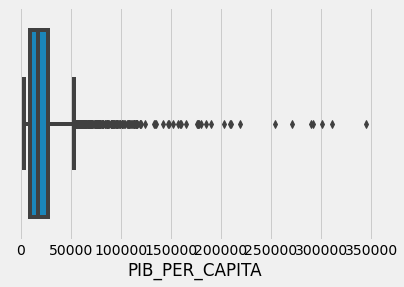

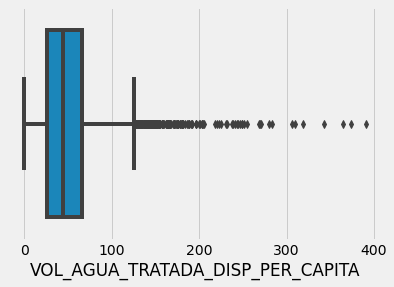

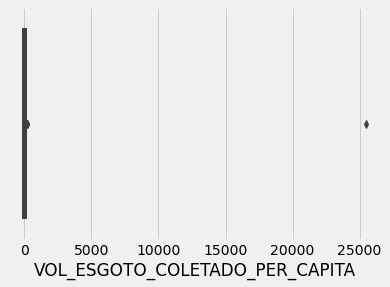

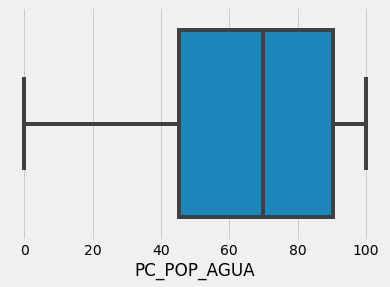

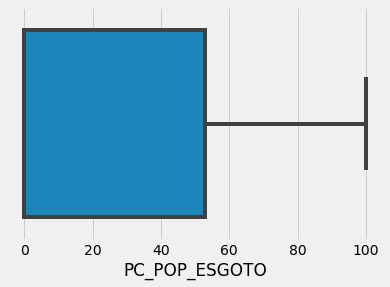

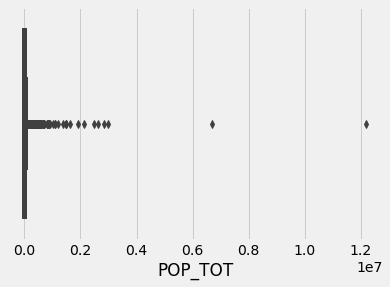

In [35]:
#Verificando visulmente a existência de outliers com boxplot
attributes = ['PIB_PER_CAPITA','VOL_AGUA_TRATADA_DISP_PER_CAPITA','VOL_ESGOTO_COLETADO_PER_CAPITA','PC_POP_AGUA', 'PC_POP_ESGOTO','POP_TOT']
for a in attributes:
    ax = sns.boxplot(x=data[a])
    plt.show()

### OBSERVAÇÕES:
   Nota-se pelos boxplot acima que POT_TOT e VOL_ESGOTO_COLETADO_PER_CAPITA necessitariam de algum tratamento de outliers. Para não deixar de fora da análise as grandes metrópoles brasileiras, irei remover outliers apenas do atributo VOL_ESGOTO_COLETADO_PER_CAPITA.<br> Considerei como outliers valores (padronizado Z) de VOL_ESGOTO_COLETADO_PER_CAPITA que fossem maiores que 3 (isso deve garantir que 99% da amostra seja preservada).


In [36]:
#O meu limite em valor padronizado Z a partir do qual considerarei um valor como outlier
z_corte = 3

In [37]:
#Identificando os outliers antes da remoção
data_out = data[np.abs((data.VOL_ESGOTO_COLETADO_PER_CAPITA - data.VOL_ESGOTO_COLETADO_PER_CAPITA.mean()) / data.VOL_ESGOTO_COLETADO_PER_CAPITA .std()) > z_corte]
data_out.sort_values(by='VOL_ESGOTO_COLETADO_PER_CAPITA', ascending=False).head()

,CODIGO_DO_MUNICIPIO,MUNICIPIO,ESTADO,ANO_DE_REFERENCIA,POP_TOT,AG001,AG007,AG015,AG018,AG019,ES001,ES005,ES006,ES012,ES013,ES014,ES015,PC_POP_AGUA,PC_POP_ESGOTO,POP_SEM_ESGOTO,POP_SEM_AGUA,VOL_AGUA_TRATADA_DISP,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,ANO,COD_UF,COD_MUNICIPIO,SIGLA_UF,REGIAO,NOME_MUNICIPIO,PIB,PIB_PER_CAPITA
1691,313055,Imbé de Minas,MG,2018,6865,"1,972.00",127.86,0.00,0.00,0.00,0.00,"174,835.00",0.00,0.00,0.00,0.00,0.00,28.73,0.00,"6,865.00","4,893.00",127,18.50,"25,467.59",2017,31,313055,MG,Sudeste,Imbé de Minas,"60,418.00","8,757.48"


In [38]:
data.shape

(5570, 32)

In [39]:
#Removendo os outliers
data = data[np.abs((data.VOL_ESGOTO_COLETADO_PER_CAPITA - data.VOL_ESGOTO_COLETADO_PER_CAPITA.mean()) / data.VOL_ESGOTO_COLETADO_PER_CAPITA .std()) <= z_corte].copy()

In [40]:
data.shape

(5569, 32)

## Análise e Exploração dos Dados

In [41]:
#Escolhendo os atributos que serão usados nas análises
atributos_para_analise = ['VOL_AGUA_TRATADA_DISP_PER_CAPITA','VOL_ESGOTO_COLETADO_PER_CAPITA','PC_POP_AGUA', 'PC_POP_ESGOTO']

In [42]:
#Dicionário com descrição dos atributos analisados
atributos_para_analise_dic = {'VOL_AGUA_TRATADA_DISP_PER_CAPITA': 'Volume de água tratada disponível per capita (m3)',
                             'VOL_ESGOTO_COLETADO_PER_CAPITA': 'Volume de esgoto coletado per capita (m3)',
                             'PC_POP_AGUA': "% da pop. com acesso a serviço de abastecimento de água",
                             'PC_POP_ESGOTO': '% da pop. com acesso a serviço de coleta de esgoto'}

### Números gerais

In [43]:
# Calculando o percentual da população brasileira com acesso à coleta de esgoto
x = round(data['ES001'].sum() / data['POP_TOT'].sum(),2)
print("% da população no Brasil com acesso à coleta de esgoto: {:.1%}".format(x))

% da população no Brasil com acesso à coleta de esgoto: 52.0%


In [44]:
# Calculando o percentual da população brasileira com acesso ao serviço de abastecimento 
#de água
x = round(data['AG001'].sum() / data['POP_TOT'].sum(),2)
print("% da população no Brasil com acesso ao serviço de água: {:.1%}".format(x))

% da população no Brasil com acesso ao serviço de água: 81.0%


### Diferenças regionais

### Diferenças regionais: Número de habitantes

In [45]:
#Obtendo a população por região do Brasil
tot = data.groupby(['REGIAO'])['POP_TOT'].sum().to_frame(name="Número de habitantes por região")
tot

,Número de habitantes por região
REGIAO,
Centro-oeste,16085885
Nordeste,56760780
Norte,18182253
Sudeste,87705081
Sul,29754036


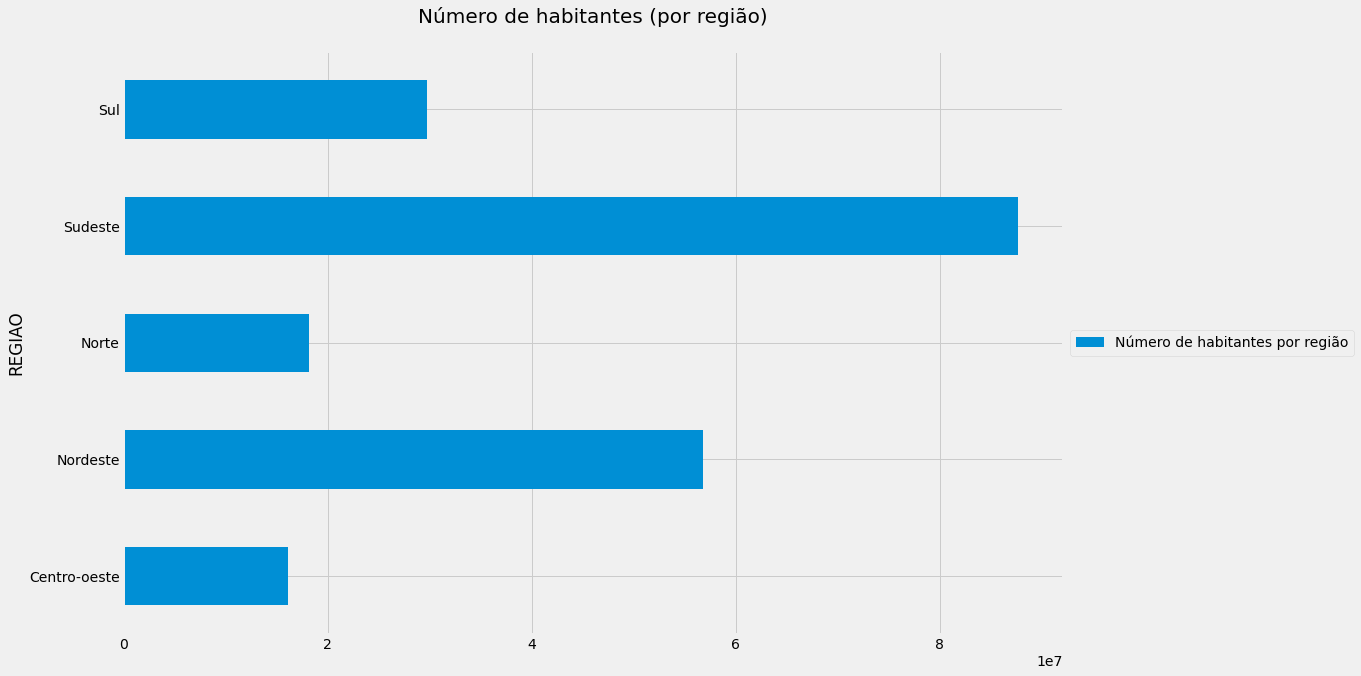

In [46]:
tot.plot.barh(rot=0, figsize=(15, 10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Número de habitantes (por região)\n', color='black', fontsize=20)
plt.show()

### Diferenças regionais: Porcentagem da população com acesso a coleta de esgoto

In [47]:
#Obtendo o percentual da população com acesso ao serviço de coleta de esgoto 
#por região do Brasil
es = data.groupby(['REGIAO'])['ES001'].sum()
tot = data.groupby(['REGIAO'])['POP_TOT'].sum()
pes = (es / tot * 100).to_frame(name="% da pop. com acesso a coleta de esgoto")
pes

,% da pop. com acesso a coleta de esgoto
REGIAO,
Centro-oeste,51.68
Nordeste,26.88
Norte,8.93
Sudeste,78.59
Sul,44.74


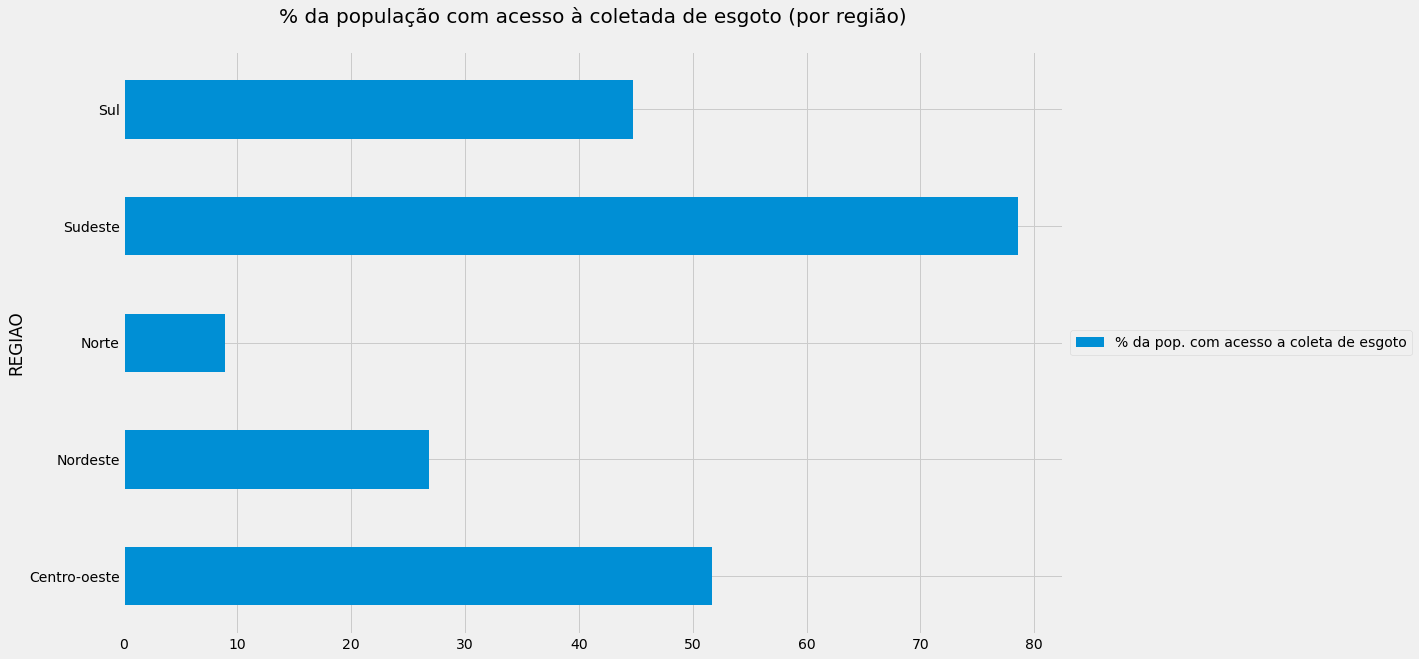

In [48]:
pes.plot.barh(rot=0, figsize=(15, 10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('% da população com acesso à coletada de esgoto (por região)\n', color='black', fontsize=20)
plt.show()

### Diferenças regionais: Porcentagem da população com acesso a serviço de abastecimento de água

In [49]:
#Obtendo o percentual da população com acesso a serviço de abastecimento de água por 
# região do Brasil
ag = data.groupby(['REGIAO'])['AG001'].sum()
tot = data.groupby(['REGIAO'])['POP_TOT'].sum()
pag = (ag / tot * 100).to_frame(name="% da pop. com acesso a serviço de abastecimento de água")
pag

,% da pop. com acesso a serviço de abastecimento de água
REGIAO,
Centro-oeste,86.94
Nordeste,71.23
Norte,48.55
Sudeste,90.31
Sul,89.33


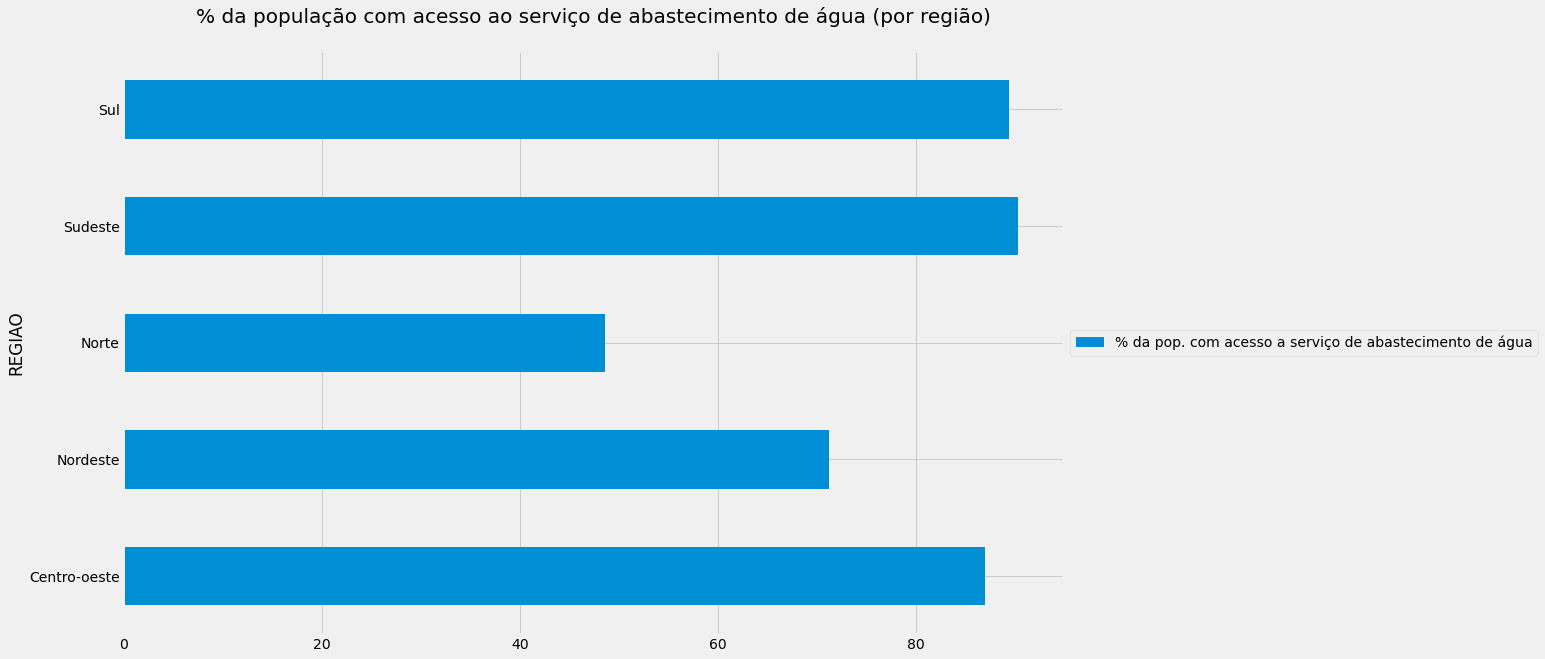

In [50]:
pag.plot.barh(rot=0, figsize=(15, 10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('% da população com acesso ao serviço de abastecimento de água (por região)\n', color='black', fontsize=20)
plt.show()

### Correlação entre os atributos

In [51]:
#Calculando as correlações
corr = data[atributos_para_analise].corr()
corr = np.round(corr, decimals=2)

In [52]:
#Exibindo as correlações com o gradiente de cor alterando de acordo com o índice 
#de correlação. Escolhemos como parâmetro cmap coolwarm (quente frio).
#Quanto menor o índice de correlação mais azul ficará a celula. Quando maior mais vermelho.
corr.style.background_gradient(cmap='coolwarm')

,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,PC_POP_AGUA,PC_POP_ESGOTO
VOL_AGUA_TRATADA_DISP_PER_CAPITA,1,0.41,0.66,0.4
VOL_ESGOTO_COLETADO_PER_CAPITA,0.41,1,0.37,0.85
PC_POP_AGUA,0.66,0.37,1,0.45
PC_POP_ESGOTO,0.4,0.85,0.45,1


### OBSERVAÇÕES DA ANÁLISE:
Como era de se esperar existe uma forte correlação entre PC_POP_ESGOTO e VOL_ESGOTO_COLETADO_PER_CAPITA. Curiosamente  a correlação entre PC_POP_AGUA e VOL_AGUA_TRATADA_DISP_PER_CAPITA é apenas moderada. Muito interessante a correção entre PC_POP_AGUA e PC_POP_ESGOTO ser apenas moderada.

### Histogramas

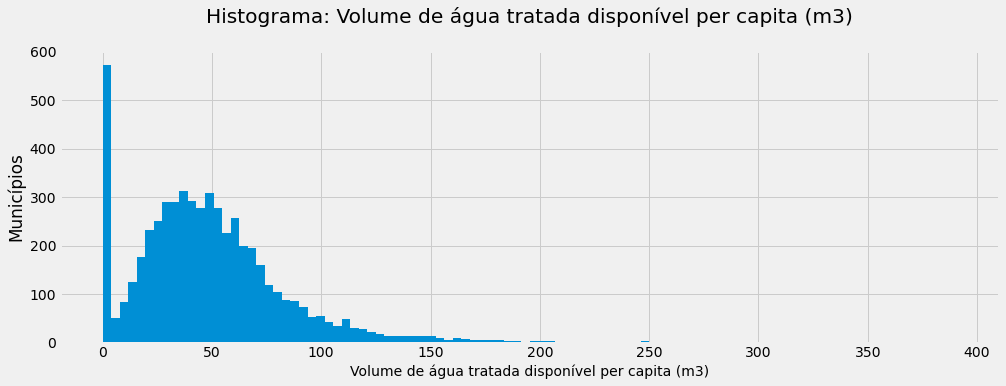

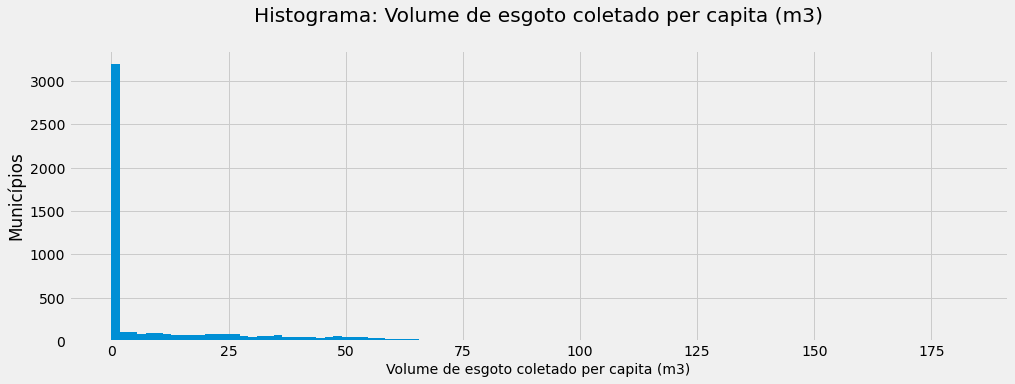

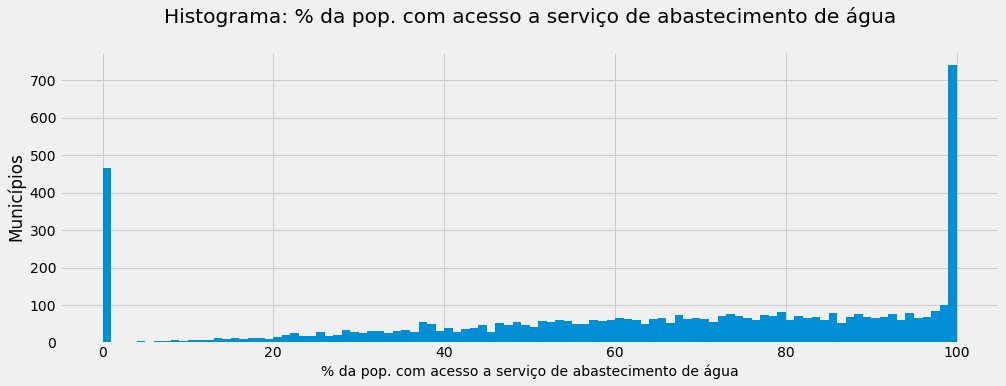

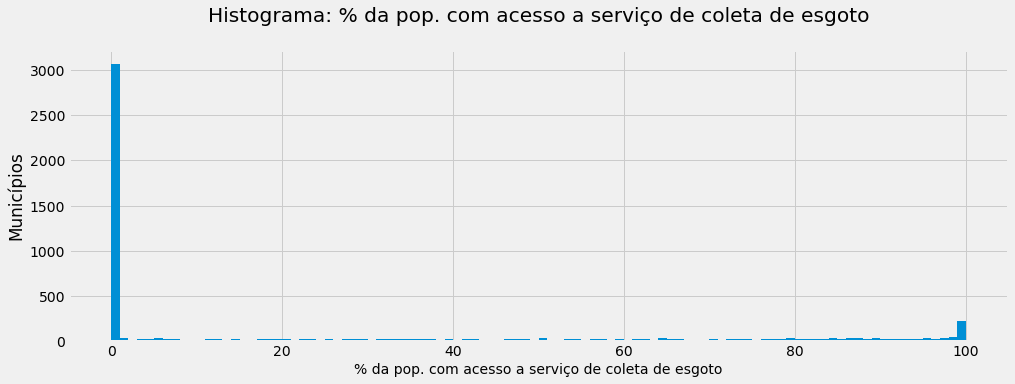

In [53]:
for i in atributos_para_analise:
    plt.figure(figsize=(15, 5))
    plt.ion()
    plt.title("Histograma: " + atributos_para_analise_dic[i] + "\n")
    plt.xlabel(atributos_para_analise_dic[i], fontsize=14)
    plt.ylabel("Municípios")
    plt.hist(data[i], bins=100)
    plt.draw()
    plt.pause(0.25)

### Estimadores estatísticos considerando todo o Brasil

In [54]:
#Obtem estimadores estatísticos 
describe_personalizado(data[atributos_para_analise])

,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,PC_POP_AGUA,PC_POP_ESGOTO
mean,49.25,14.33,64.24,25.61
std,37.29,24.14,30.31,35.27
std / mean,0.76,1.68,0.47,1.38


### Estimadores estatísticos por região

In [55]:
regioes = data.groupby(['REGIAO']).REGIAO.nunique().index.tolist()
for r in regioes:
    display(HTML("<b>Estimadores estatísticos da região " + r + "</b>"))
    display(describe_personalizado(data[atributos_para_analise][data['REGIAO'] == r]))

,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,PC_POP_AGUA,PC_POP_ESGOTO
mean,54.89,8.01,67.27,16.12
std,39.17,14.67,28.89,26.30
std / mean,0.71,1.83,0.43,1.63


,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,PC_POP_AGUA,PC_POP_ESGOTO
mean,36.28,4.73,56.50,10.18
std,31.44,13.19,30.92,21.76
std / mean,0.87,2.79,0.55,2.14


,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,PC_POP_AGUA,PC_POP_ESGOTO
mean,35.58,1.42,40.94,3.04
std,38.36,5.91,32.45,11.45
std / mean,1.08,4.17,0.79,3.76


,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,PC_POP_AGUA,PC_POP_ESGOTO
mean,62.09,35.04,72.00,58.47
std,37.66,30.07,25.68,35.98
std / mean,0.61,0.86,0.36,0.62


,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,PC_POP_AGUA,PC_POP_ESGOTO
mean,53.77,7.17,72.67,15.11
std,35.87,15.22,27.47,27.69
std / mean,0.67,2.12,0.38,1.83


In [56]:
#Obtendo os valores do quartil por POPULACAO_ESTIMADA
quartis_pop_estimada = []
quartis_pop_estimada.append(math.floor(data['POP_TOT'].min()))
quartis_pop_estimada.append(math.floor(data['POP_TOT'].quantile(.25)))
quartis_pop_estimada.append(math.floor(data['POP_TOT'].quantile(.50)))
quartis_pop_estimada.append(math.floor(data['POP_TOT'].quantile(.75)))
quartis_pop_estimada.append(math.floor(data['POP_TOT'].max()))

#Obtem valoes dos quartis de PIB_PER_CAPTA dos municípios
quartis_pib_per_capita = []
quartis_pib_per_capita.append(math.floor(data['PIB_PER_CAPITA'].min()))
quartis_pib_per_capita.append(math.floor(data['PIB_PER_CAPITA'].quantile(.25)))
quartis_pib_per_capita.append(math.floor(data['PIB_PER_CAPITA'].quantile(.50)))
quartis_pib_per_capita.append(math.floor(data['PIB_PER_CAPITA'].quantile(.75)))
quartis_pib_per_capita.append(math.floor(data['PIB_PER_CAPITA'].max()))

In [57]:
#Obtem estimador estatistico de média por quartil de POP_TOT dos municípios
data_desc_pop_estimada = data.groupby(pd.cut(data["POP_TOT"], [quartis_pib_per_capita[0],quartis_pib_per_capita[1],quartis_pib_per_capita[2],quartis_pib_per_capita[3],quartis_pib_per_capita[4]]))[atributos_para_analise].mean()

In [58]:
#Obtem estimador estatistico de média por quartil de PIB_PER_CAPTA dos municípios
data_desc_pib_per_capta = data.groupby(pd.cut(data["PIB_PER_CAPITA"], [quartis_pib_per_capita[0],quartis_pib_per_capita[1],quartis_pib_per_capita[2],quartis_pib_per_capita[3],quartis_pib_per_capita[4]]))[atributos_para_analise].mean()

In [59]:
display(HTML("<b>Médias por quartil de quantidade de habitantes</b>"))
data_desc_pop_estimada

,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,PC_POP_AGUA,PC_POP_ESGOTO
POP_TOT,,,,
"(3285, 9492]",43.83,11.88,60.35,19.95
"(9492, 16599]",43.29,12.44,60.02,22.73
"(16599, 27051]",47.09,13.87,62.79,25.14
"(27051, 344847]",61.69,19.78,73.22,37.65


In [60]:
display(HTML("<b>Médias por quartil de PIB per capita</b>"))
data_desc_pib_per_capta

,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,PC_POP_AGUA,PC_POP_ESGOTO
PIB_PER_CAPITA,,,,
"(3285, 9492]",28.83,4.62,48.39,9.26
"(9492, 16599]",44.48,13.12,60.81,23.47
"(16599, 27051]",55.38,18.35,69.62,32.31
"(27051, 344847]",68.27,21.20,78.12,37.34


## Criação de Modelos de Machine Learning: Criando agrupamentos (clusters)

O objetivo do agrupamento é detectar grupos de municípios com características semelhantes do ponto de vista de atratividade a investidores interessados em participar de leilões de concessão de serviços de saneamento básico. Isso pode auxiliar na formação de lotes de municípios em futuros leilões.

Note que a escolha dos atributos é algo crítico nesse caso. Precisam ser escolhidos atributos que afetem o interesse dos investidores. Nesse caso a quantidade de pessoas no município sem acesso aos serviços de abastecimento de água e coleta de esgoto representam o mercado potencial para o investidor, e o PIB per capita indica um fator de risco de inadimplência.

Devido às grandes diferenças que existem entre as regiões do Brasil a melhor estratégia é se trabalhar por região separadamente.

In [61]:
#Seleciona os atributos sobre os municípios que serão usados para obter os clusters
# POP_SEM_AGUA
# POP_SEM_ESGOTO
# PIB_PER_CAPITA

cluster_attributes = ['POP_SEM_ESGOTO', 'POP_SEM_AGUA', 'PIB_PER_CAPITA']

### Aqui é escolhida a região do Brasil que será submetida ao estudo de agrupamentos

In [62]:
data = data[data['REGIAO'] == REGIAO_ANALISADA].copy()

In [63]:
#Verifica se existem valores nulos
data[cluster_attributes].isnull().sum()

POP_SEM_ESGOTO    0
POP_SEM_AGUA      0
PIB_PER_CAPITA    0
dtype: int64

In [64]:
# Como os atributos envolvem escalas de medidas diferentes é necessário normalizar os
# atributos antes de se usar técnicas de obtenção de clusters que envolvem cálculo de 
# distância vetorial. Para normalização optei por converter os valores segundo a fórmula
# z = (x - u) / s
data_norm = StandardScaler().fit_transform(data[cluster_attributes])

In [65]:
data_norm.shape

(1794, 3)

### Criando agrupamentos com algoritmo K-Means

**Nota metodológica:** Inertia ou "within-cluster sum-of-squares" pode ser interpretada como uma medida que indica o quanto um cluster é internamente coeso. Quanto menor o valor,  mais coeso estão os elementos do cluster. No algoritmo K-Means quanto maior o número de clusters que fornecemos como hiperparâmetro, naturalmente mais coesos ficarão os elementos de cada um dos grupos. Mas se levarmos em conta apenas a medida de coesão chegaremos ao absurdo de concluir que devemos ter tantos grupos quantos os elementos a serem agrupados! Uma técnica para se estimar um número de clusters adequado é ir incrementando gradualmente o número de clusters e medir a inertia. Quando o valor medido de inertia começar a variar pouco em relação ao incremento na quantidade de cluster é sinal que aquele é um valor bom para se escolher como número de clusters. Visualmente esse ponto parece uma guinada na curva o que faz o método receber o nome de "elbow" (cotovelo).

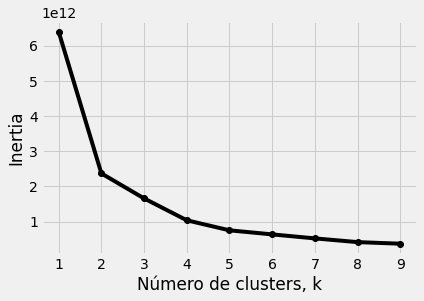

In [66]:
#Obtendo o valor ótimo de k (número de clusters) através da medição de inertia.
#O valor ótimo é o ponto a partir do qual a redução da medida de inertia torna-se muito pequena em relação
#ao aumento de k. Este ponto costuma ser chamado de elbow (cotovelo).

ks = range(1, 10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    model.fit(data[cluster_attributes])
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('Número de clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [67]:
#Criando os agrupamentos através do algoritmo KMeans
n_clust = 2
kmeans = KMeans(n_clusters=n_clust, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(data_norm)

**Nota metodológica:** Como é calculado o silhouette score?

Sendo:

a = distância média entre os elementos dentro do cluster;  
b = distância média entre cada elemento do cluster e o clusters mais próximo

silhouette score = (b - a) / max(a, b)

O valor de silhouette score varia entre +1 e -1. Sendo +1 o melhor caso e -1 o pior.


In [72]:
n_clusters_ = len(set(kmeans.labels_))

In [73]:
# Silhouette_score varia entre -1 a +1. Quanto mais próximo de +1 melhor.
print('Número estimado de clusters: %d' % n_clusters_)
print("Silhouette score: %0.3f" % silhouette_score(data_norm, kmeans.labels_))

Número estimado de clusters: 2
Silhouette score: 0.930


In [74]:
#Obtem uma lista com os centróides dos clusters
centroids = kmeans.cluster_centers_

In [75]:
centroids.shape

(2, 3)

In [76]:
#Dando uma olhada no conteúdos das lista centroids
pd.DataFrame(centroids)

,0,1,2
0,-0.06,-0.05,-0.01
1,11.47,9.21,1.08


In [77]:
#Adicionando uma nova coluna ao dataframe data com a informação do cluster
predict=kmeans.predict(data_norm)
data['Cluster_KMean'] = pd.Series(predict, index=data.index)

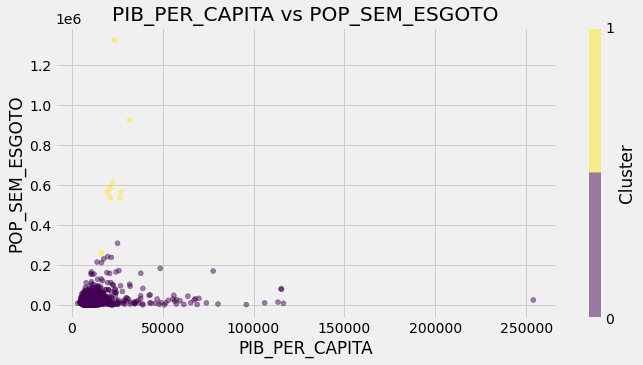

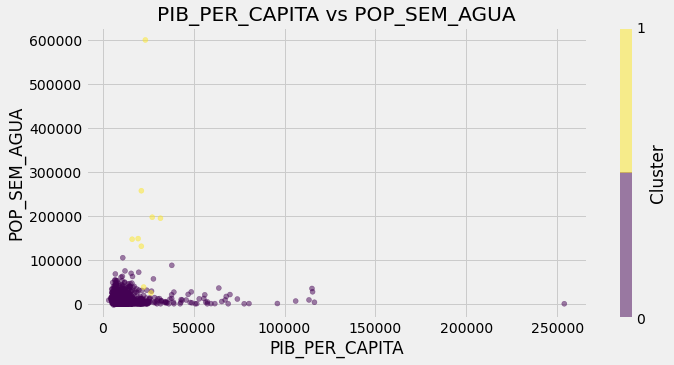

In [78]:
#Construindo vários gráficos de dispersão envolvendo a combinação de diversos atributos com
#a cor de cada elemento (ponto) indicando o cluster ao qual o elemento pertence.
cluster_attributes_x = ['PIB_PER_CAPITA']
cluster_attributes_y = ['POP_SEM_ESGOTO','POP_SEM_AGUA']

for x in cluster_attributes_x:
    for y in cluster_attributes_y:
        if (x != y):
            plt.figure(figsize=(10, 5))
            plt.ion()
            plt.title(x + " vs " + y)
            plt.xlabel(x)
            plt.ylabel(y)
            plt.scatter(data[x], data[y], c=kmeans.labels_.astype(int), s=25, alpha=0.5, cmap=plt.cm.get_cmap('viridis', n_clust))
            plt.colorbar(ticks=range(n_clust),label='Cluster')
            plt.draw()
            plt.pause(0.25)


In [79]:
#Contando quantos municípios existem em cada grupo
data.groupby('Cluster_KMean').size().to_frame()

,0
Cluster_KMean,
0,1785
1,9


In [80]:
#Olhando a média dos valores dos atributos que foram usados para o agrupamento
#agrupados pelo atributo Cluster_KMean.
data[cluster_attributes + ['Cluster_KMean']].groupby('Cluster_KMean').mean()

,POP_SEM_ESGOTO,POP_SEM_AGUA,PIB_PER_CAPITA
Cluster_KMean,,,
0,"19,944.14","8,177.14","11,146.68"
1,"655,998.78","192,915.78","23,274.36"


In [81]:
#Escolhendo os atributos para visualização
view_attributes = ['MUNICIPIO', 'ESTADO', 'POP_TOT', 'PC_POP_AGUA', 'PC_POP_ESGOTO', 'VOL_AGUA_TRATADA_DISP_PER_CAPITA', 'VOL_ESGOTO_COLETADO_PER_CAPITA'] + cluster_attributes + ['Cluster_KMean']

In [82]:
#Visualiando uma amostra dos elementos classificados como Cluster 0 segundo o algorítmo KMeans
#ordenado em ordem descrescente de POT_TOT
data[data['Cluster_KMean'] == 0].sort_values(by='POP_TOT', ascending=False)[view_attributes].head(10)

,MUNICIPIO,ESTADO,POP_TOT,PC_POP_AGUA,PC_POP_ESGOTO,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,POP_SEM_ESGOTO,POP_SEM_AGUA,PIB_PER_CAPITA,Cluster_KMean
2655,João Pessoa,PB,800323,100.00,79.30,81.99,44.74,"165,631.00",0.00,"24,319.82",0
4713,Aracaju,SE,648939,99.78,52.45,81.60,30.34,"308,593.00","1,455.00","25,185.55",0
332,Feira de Santana,BA,609913,98.06,60.96,63.13,27.69,"238,081.00","11,805.00","21,765.41",0
2611,Campina Grande,PB,407472,100.00,90.29,60.90,34.94,"39,580.00",0.00,"21,077.30",0
2896,Olinda,PE,391835,99.23,45.17,70.12,15.06,"214,836.00","3,011.00","13,917.85",0
2829,Caruaru,PE,356872,100.00,54.61,51.02,14.39,"161,979.00",0.00,"19,311.06",0
2911,Petrolina,PE,343865,100.00,83.51,64.39,25.92,"56,712.00",0.00,"17,454.51",0
614,Vitória da Conquista,BA,338885,100.00,92.23,49.43,31.94,"26,332.00",0.00,"18,589.99",0
2907,Paulista,PE,329117,100.00,52.90,73.01,12.13,"155,001.00",0.00,"12,240.33",0
3771,Mossoró,RN,294076,100.00,46.24,89.54,20.08,"158,094.00",1.00,"20,858.33",0


In [83]:
#Visualiando uma amostra dos elementos classificados como Cluster 1 segundo o algorítmo KMeans
#ordenado em ordem descrescente de POT_TOT
data[data['Cluster_KMean'] == 1].sort_values(by='POP_TOT', ascending=False)[view_attributes].head(10)

,MUNICIPIO,ESTADO,POP_TOT,PC_POP_AGUA,PC_POP_ESGOTO,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,POP_SEM_ESGOTO,POP_SEM_AGUA,PIB_PER_CAPITA,Cluster_KMean
537,Salvador,BA,2857329,91.01,81.29,95.35,50.69,"534,726.00","256,952.00","21,231.48",1
677,Fortaleza,CE,2643247,77.31,49.89,70.83,20.91,"1,324,454.00","599,781.00","23,436.66",1
2917,Recife,PE,1637834,88.12,43.54,98.29,27.19,"924,735.00","194,525.00","31,743.72",1
1313,São Luís,MA,1094667,82.02,48.26,61.94,27.98,"566,430.00","196,777.00","27,226.41",1
68,Maceió,AL,1012382,87.08,42.19,69.37,11.72,"585,228.00","130,760.00","21,210.09",1
3772,Natal,RN,877640,97.19,39.08,96.38,21.93,"534,621.00","24,668.00","26,497.08",1
3185,Teresina,PI,861442,95.59,29.25,123.45,9.53,"609,442.00","38,010.00","22,481.67",1
2872,Jaboatão dos Guararapes,PE,697636,78.77,19.22,56.69,4.75,"563,523.00","148,085.00","19,463.25",1
662,Caucaia,CE,363982,59.70,28.34,44.55,10.09,"260,830.00","146,684.00","16,178.90",1


**OBSERVAÇÕES DA ANÁLISE:** 

A quantidade de elementos por cluster é bastante desigual. O algoritmo KMeans se mostrou inadequado para o problema.


### Criando agrupamentos com algoritmo DBScan

**Nota metodológica:** Significado de alguns hiperparâmetros: 

**eps:** Dois pontos são considerados vizinhos se a distância entre eles é menor que o valor do 'eps'. Intuitivamente é como se ele fosse o valor do raio num gráfico de 2 dimensões.  
**min_samples:** É a quantidade mínima de elementos que cada cluster deve ter.  

O gráfico abaixo mostra o valor de eps vs número de elementos vizinho. Quanto maior o valor do eps, mais elementos ele irá embarcar e consequentemente menor será a quantidade de agrupamentos obtidos.

In [84]:
#NearestNeighbors irá retornar na lista bidimensional 'distances' a distância entre cada um dos
#elementos. A lista 'indices' não é utilizada; consta na atribuição apenas para separação
#dos arrays de distância e indices fornecidos por NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=len(data_norm)).fit(data_norm)
distances, indices = nbrs.kneighbors(data_norm)

In [85]:
distances.shape

(1794, 1794)

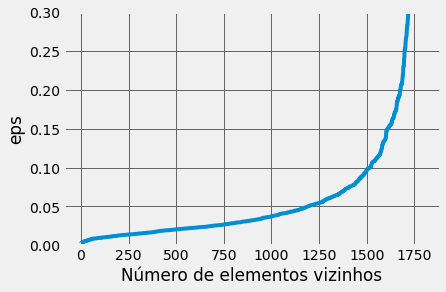

In [86]:
#Construindo gráfico para avaliar o melhor valor para eps. Ajuste a escala com plt.ylim
#conforme a necessidade
distances2 = np.sort(distances, axis=0)
distances2 = distances2[:,1]
plt.plot(distances2)
plt.grid(b=True, which='both', color='#666666', linestyle='-')
plt.ylim(0, 0.3)
plt.xlabel('Número de elementos vizinhos')
plt.ylabel('eps')
plt.show()

In [87]:
#Analisando o gráfico escolhemos o melhor valor para best_eps e best_min_samples
#Uma forma de se estimar o hyperparâmetro min_samples é usar a fórmula 
#min_samples = ln(n)
best_eps = 0.2
best_min_samples = int(math.log(math.sqrt(distances.size)))

In [88]:
#eps é o raio de distãncia
dbs = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(data_norm)

**Nota metodológica:** 

Como é calculado o silhouette score?  

Sendo:  
a = distância média entre os elementos dentro do cluster;  
b = distância média entre cada elemento do cluster e o clusters mais próximo  


silhouette score = (b - a) / max(a, b)

O valor de silhouette score varia entre +1 e -1. Sendo +1 o melhor caso e -1 o pior.


In [89]:
n_clusters_ = len(set(dbs.labels_)) - (1 if -1 in dbs.labels_ else 0)
n_noise_ = list(dbs.labels_).count(-1)

In [90]:
# Silhouette_score varia entre -1 a +1. Quanto mais próximo de +1 melhor.
print('Número estimado de clusters: %d' % n_clusters_)
print('Número estimado de pontos de ruído (noise points): %d' % n_noise_)
print("Silhouette score: %0.3f" % silhouette_score(data_norm, dbs.labels_))

Número estimado de clusters: 1
Número estimado de pontos de ruído (noise points): 233
Silhouette score: 0.672


In [91]:
#adicionando uma nova coluna com a informação do cluster
predict = dbs.fit_predict(data_norm)
data['Cluster_DBScan'] = pd.Series(predict, index=data.index)

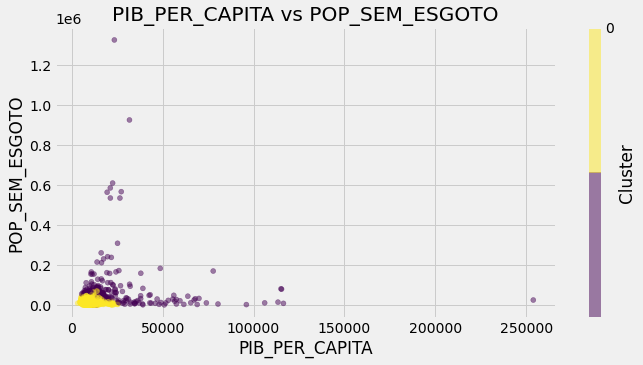

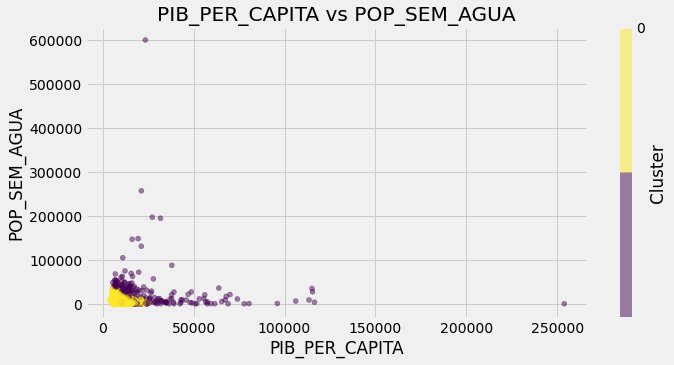

In [92]:
#Construindo vários gráficos de dispersão envolvendo a combinação de diversos atributos com
#a cor de cada elemento (ponto) indicando o cluster ao qual o elemento pertence.
cluster_attributes_x = ['PIB_PER_CAPITA']
cluster_attributes_y = ['POP_SEM_ESGOTO','POP_SEM_AGUA']


for x in cluster_attributes_x:
    for y in cluster_attributes_y:
        if (x != y):
            plt.figure(figsize=(10, 5))
            plt.ion()
            plt.title(x + " vs " + y)
            plt.xlabel(x)
            plt.ylabel(y)
            plt.scatter(data[x], data[y], c=dbs.labels_.astype(int), s=25, alpha=0.5, cmap=plt.cm.get_cmap('viridis', n_clust))
            plt.colorbar(ticks=range(n_clust),label='Cluster')
            plt.draw()
            plt.pause(0.25)


In [93]:
#Olhando a média dos valores dos atributos que foram usados para o agrupamento
#agrupados pelo atributo Cluster_DBScan.
data[cluster_attributes + ['Cluster_DBScan']].groupby('Cluster_DBScan').mean()

,POP_SEM_ESGOTO,POP_SEM_AGUA,PIB_PER_CAPITA
Cluster_DBScan,,,
-1,"83,361.25","26,310.28","25,572.90"
0,"14,145.49","6,535.65","9,063.29"


In [94]:
#Contando quantos municípios existem em cada grupo
data.groupby('Cluster_DBScan').size().to_frame()

,0
Cluster_DBScan,
-1,233
0,1561


In [95]:
#Contando quantos municípios existem em cada grupo por estado
data.groupby(['ESTADO','Cluster_DBScan']).size().to_frame()

0
ESTADO Cluster_DBScan     
AL     -1               13
        0               89
BA     -1               44
        0              373
CE     -1               47
        0              137
MA     -1               37
        0              180
PB     -1               11
        0              212
PE     -1               35
        0              150
PI     -1               15
        0              209
RN     -1               21
        0              146
SE     -1               10
        0               65

In [96]:
#Escolhendo os atributos para visualização
view_attributes = ['MUNICIPIO', 'ESTADO', 'PC_POP_AGUA', 'PC_POP_ESGOTO', 'VOL_AGUA_TRATADA_DISP_PER_CAPITA', 'VOL_ESGOTO_COLETADO_PER_CAPITA'] + cluster_attributes + ['Cluster_DBScan']

In [97]:
#Visualiando uma amostra dos elementos classificados como Cluster 0 segundo o algorítmo DBScan
#ordenado em ordem descrescente de POT_TOT
data[data['Cluster_DBScan'] == 0].sort_values(by='POP_TOT', ascending=False)[view_attributes].head(10)

,MUNICIPIO,ESTADO,PC_POP_AGUA,PC_POP_ESGOTO,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,POP_SEM_ESGOTO,POP_SEM_AGUA,PIB_PER_CAPITA,Cluster_DBScan
614,Vitória da Conquista,BA,100.00,92.23,49.43,31.94,"26,332.00",0.00,"18,589.99",0
785,Sobral,CE,100.00,95.98,88.83,21.48,"8,312.00",0.00,"21,679.33",0
414,Jequié,BA,100.00,88.21,50.20,38.04,"18,371.00",0.00,"15,765.90",0
3813,São Gonçalo do Amarante,RN,100.00,30.79,74.83,18.03,"69,975.00",2.00,"13,935.05",0
606,Valença,BA,86.00,73.00,85.05,29.73,"25,882.00","13,420.00","14,534.73",0
2943,Serra Talhada,PE,100.00,77.78,61.93,11.83,"19,061.00",0.00,"15,628.85",0
344,Guanambi,BA,100.00,62.75,53.37,24.27,"31,292.00",0.00,"14,558.12",0
395,Itapetinga,BA,100.00,94.00,72.64,27.48,"4,529.00",0.00,"13,955.55",0
104,Rio Largo,AL,79.18,31.03,63.80,6.27,"51,618.00","15,582.00","13,424.77",0
2798,Arcoverde,PE,100.00,5.03,55.54,1.50,"70,129.00",0.00,"13,278.18",0


In [98]:
#Visualiando uma amostra dos elementos classificados como Cluster -1 segundo o algorítmo DBScan
#ordenado em ordem descrescente de POT_TOT
data[data['Cluster_DBScan'] == -1].sort_values(by='POP_TOT', ascending=False)[view_attributes].head(10)

,MUNICIPIO,ESTADO,PC_POP_AGUA,PC_POP_ESGOTO,VOL_AGUA_TRATADA_DISP_PER_CAPITA,VOL_ESGOTO_COLETADO_PER_CAPITA,POP_SEM_ESGOTO,POP_SEM_AGUA,PIB_PER_CAPITA,Cluster_DBScan
537,Salvador,BA,91.01,81.29,95.35,50.69,"534,726.00","256,952.00","21,231.48",-1
677,Fortaleza,CE,77.31,49.89,70.83,20.91,"1,324,454.00","599,781.00","23,436.66",-1
2917,Recife,PE,88.12,43.54,98.29,27.19,"924,735.00","194,525.00","31,743.72",-1
1313,São Luís,MA,82.02,48.26,61.94,27.98,"566,430.00","196,777.00","27,226.41",-1
68,Maceió,AL,87.08,42.19,69.37,11.72,"585,228.00","130,760.00","21,210.09",-1
3772,Natal,RN,97.19,39.08,96.38,21.93,"534,621.00","24,668.00","26,497.08",-1
3185,Teresina,PI,95.59,29.25,123.45,9.53,"609,442.00","38,010.00","22,481.67",-1
2655,João Pessoa,PB,100.00,79.30,81.99,44.74,"165,631.00",0.00,"24,319.82",-1
2872,Jaboatão dos Guararapes,PE,78.77,19.22,56.69,4.75,"563,523.00","148,085.00","19,463.25",-1
4713,Aracaju,SE,99.78,52.45,81.60,30.34,"308,593.00","1,455.00","25,185.55",-1


### Obtendo regras de agrupamentos de municípios a partir do algoritmo de 'Árvore de Decisão' sobre os agrupamentos obtidos anteriormente com o algoritmo DBScan

In [99]:
#Os atributos usados para inferência serão os da lista cluster_attributes
X = data[cluster_attributes]

In [100]:
#O atributo alvo de aprendizado será a classificação obtida anterirmente e armazenada
#no atributo 'Cluster_DBScan'
y = data['Cluster_DBScan'].astype(int)

In [101]:
#Divide os dados em dois conjuntos. Um de treino e outro de teste.
#Usarei nesse caso 75% dos meus registros par treino e 25% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=False)

In [102]:
X_train.shape

(1345, 3)

In [103]:
X_test.shape

(449, 3)

**Nota metodológica:** Para evitar que a árvore cresça muito em profundidade e torne o resultamo initeligível, optei por limitar a profundidade da árvore ao segundo nível através do parâmetro max_depth=2. Isso irá tornar a regra fácil de ser transformada em uma norma ou ser explicada para um gestor público.

In [104]:
#Treinamento do modelo usando o algoritmo de classificação por árvore de decisão
#Para o trino foi usado o conjunto de treinamento
decision_tree_model = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree_model.fit(X_train, np.array(y_train).ravel())

DecisionTreeClassifier(max_depth=2, random_state=0)

In [105]:
#Prevendo os valores para o conjungo de teste utilizando o aprendizida acima
y_pred = decision_tree_model.predict(X_test)

**Nota metodológica:** Após efetuarmos o treinamento, tentamos prever no passo acima quais seriam os valores do atributo Cluster_DBScan para o conjunto de teste. Ao confrontar os valores previstos para Cluster_DBScan com os valores reais obtemos uma matriz de confusão com os números de falsos positivos, falsos negativos, positivos verdadeiros e negativos verdadeiros. A partir desses é possível calcular os valores de precisão, recall e F1 Score para avaliação do modelo.

In [106]:
#Obtendo a matriz de confusão
cm = confusion_matrix(y_test.values, y_pred)
print(cm)

[[ 41   5]
 [  6 397]]


In [107]:
#Calculando precisão, recall e f1_score
score = precision_recall_fscore_support(y_test.values, y_pred, zero_division=0, average='micro')
precision = score[0]
recall = score[1]
f1_score = score[2]

In [108]:
print("Precision: %.2f%%" %(precision*100))
print("Recall: %.2f%%" %(recall*100))
print("F1 Score: %.2f%%" %(recall*100))

Precision: 97.55%
Recall: 97.55%
F1 Score: 97.55%


### OBSERVAÇÕES DA ANÁLISE:  
   Pelos valores de precisão, recall e F1 score conclui-se que o modelo de aprendizado usando o algoritmo de árvore de decisão até o primeiro nível teve um alto nível de acerto ao tentar prever o agrupamento (cluster usando DBScan) ao qual o município pertence.

In [109]:
#Exportando as regras inferidos durante o treinamento. Por questões de inteligibilidade
#serão exibidas as regrs apenas até o segundo nível
r = export_text(decision_tree_model, feature_names=list(data[cluster_attributes].columns), max_depth=2)
print (r)

|--- POP_SEM_ESGOTO <= 41749.00
|   |--- PIB_PER_CAPITA <= 24353.61
|   |   |--- class: 0
|   |--- PIB_PER_CAPITA >  24353.61
|   |   |--- class: -1
|--- POP_SEM_ESGOTO >  41749.00
|   |--- POP_SEM_ESGOTO <= 54076.50
|   |   |--- class: -1
|   |--- POP_SEM_ESGOTO >  54076.50
|   |   |--- class: -1



### OBSERVAÇÕES DA ANÁLISE:  
Considerando a região analisada, presume-se que os municípios classificados pelo algoritmo DBScan como grupo -1 serão aqueles com maior atratividade para os interessados em participar de leilões para concessão de serviço de saneamento básico.

Um município dessa região pertencerá a esse grupo (-1) se possuir uma população sem acesso ao serviço de coleta de esgoto maior que 41.749 habitantes (mercado potencial), ou ainda, se mesmo possuindo menos de 41.749 habitantes possuir renda per capita anual maior que R$24.353,61 (representando menor risco de inadimplência).

## Referências

ALADE, Tola. Tutorial: How to determine the optimal number of clusters for k-means clusterin. **cambridgespark.com**, 2018. Disponível em:  https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f. Acesso em: 02 de jul. de 2020.  

BIRANT, Derya et al. ST-DBSCAN: An algorithm for clustering spatial–temporal data. **researchgate.net**, 2007. Disponível em: https://www.researchgate.net/publication/223059919_ST-DBSCAN_An_algorithm_for_clustering_spatial-temporal_data. Acesso em: 07 de jul. de 2020.

CLUSTERING. **scikit-learn.org**, 2019. Disponível em: https://scikit-learn.org/stable/modules/clustering.html#clustering. Acesso em: 02 de jul. de 2020. 

DBSCAN. **wikipedia.org**, 2020. Disponível em: https://en.wikipedia.org/wiki/DBSCAN. Acesso em: 02 de jul. de 2020. 

K-MEANS CLUSTERING. **wikipedia.org**, 2020. Disponível em: https://en.wikipedia.org/wiki/K-means_clustering. Acesso em:  02 de jul. de 2020. 

MAKLIN, Cory. K-means Clustering Python Example. **towardsdatascience.com**, 2018. Disponível em: https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203. Acesso em: 02 de jul. de 2020.  

MAKLIN, Cory. DBSCAN Python Example: The Optimal Value For Epsilon (EPS).  **towardsdatascience.com**, 2019. Disponível em: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc. Acesso em: 02 de jul. de 2020.  

SHIMAKURA, Silvia. Interpretação do coeficiente de correlação. **Laboratório de Estatística e Geoinformação**, 2006. Disponível em: :http://leg.ufpr.br/~silvia/CE003/node74.html. Acesso em: 02 de jul. de 2020.  

SHUNG, Koo Ping. Accuracy, Precision, Recall or F1?. **towardsdatascience.com**, 2015. Disponível em:https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. Acessado em: 09 de jul. 2020. 